# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [6]:
file_path = "D:/PythonProjects/MY_PYTHON_WAY/PYTHON_DATA-SCIENS/HomeWork_4/bikes_rent.csv"
df = pd.read_csv(file_path)
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

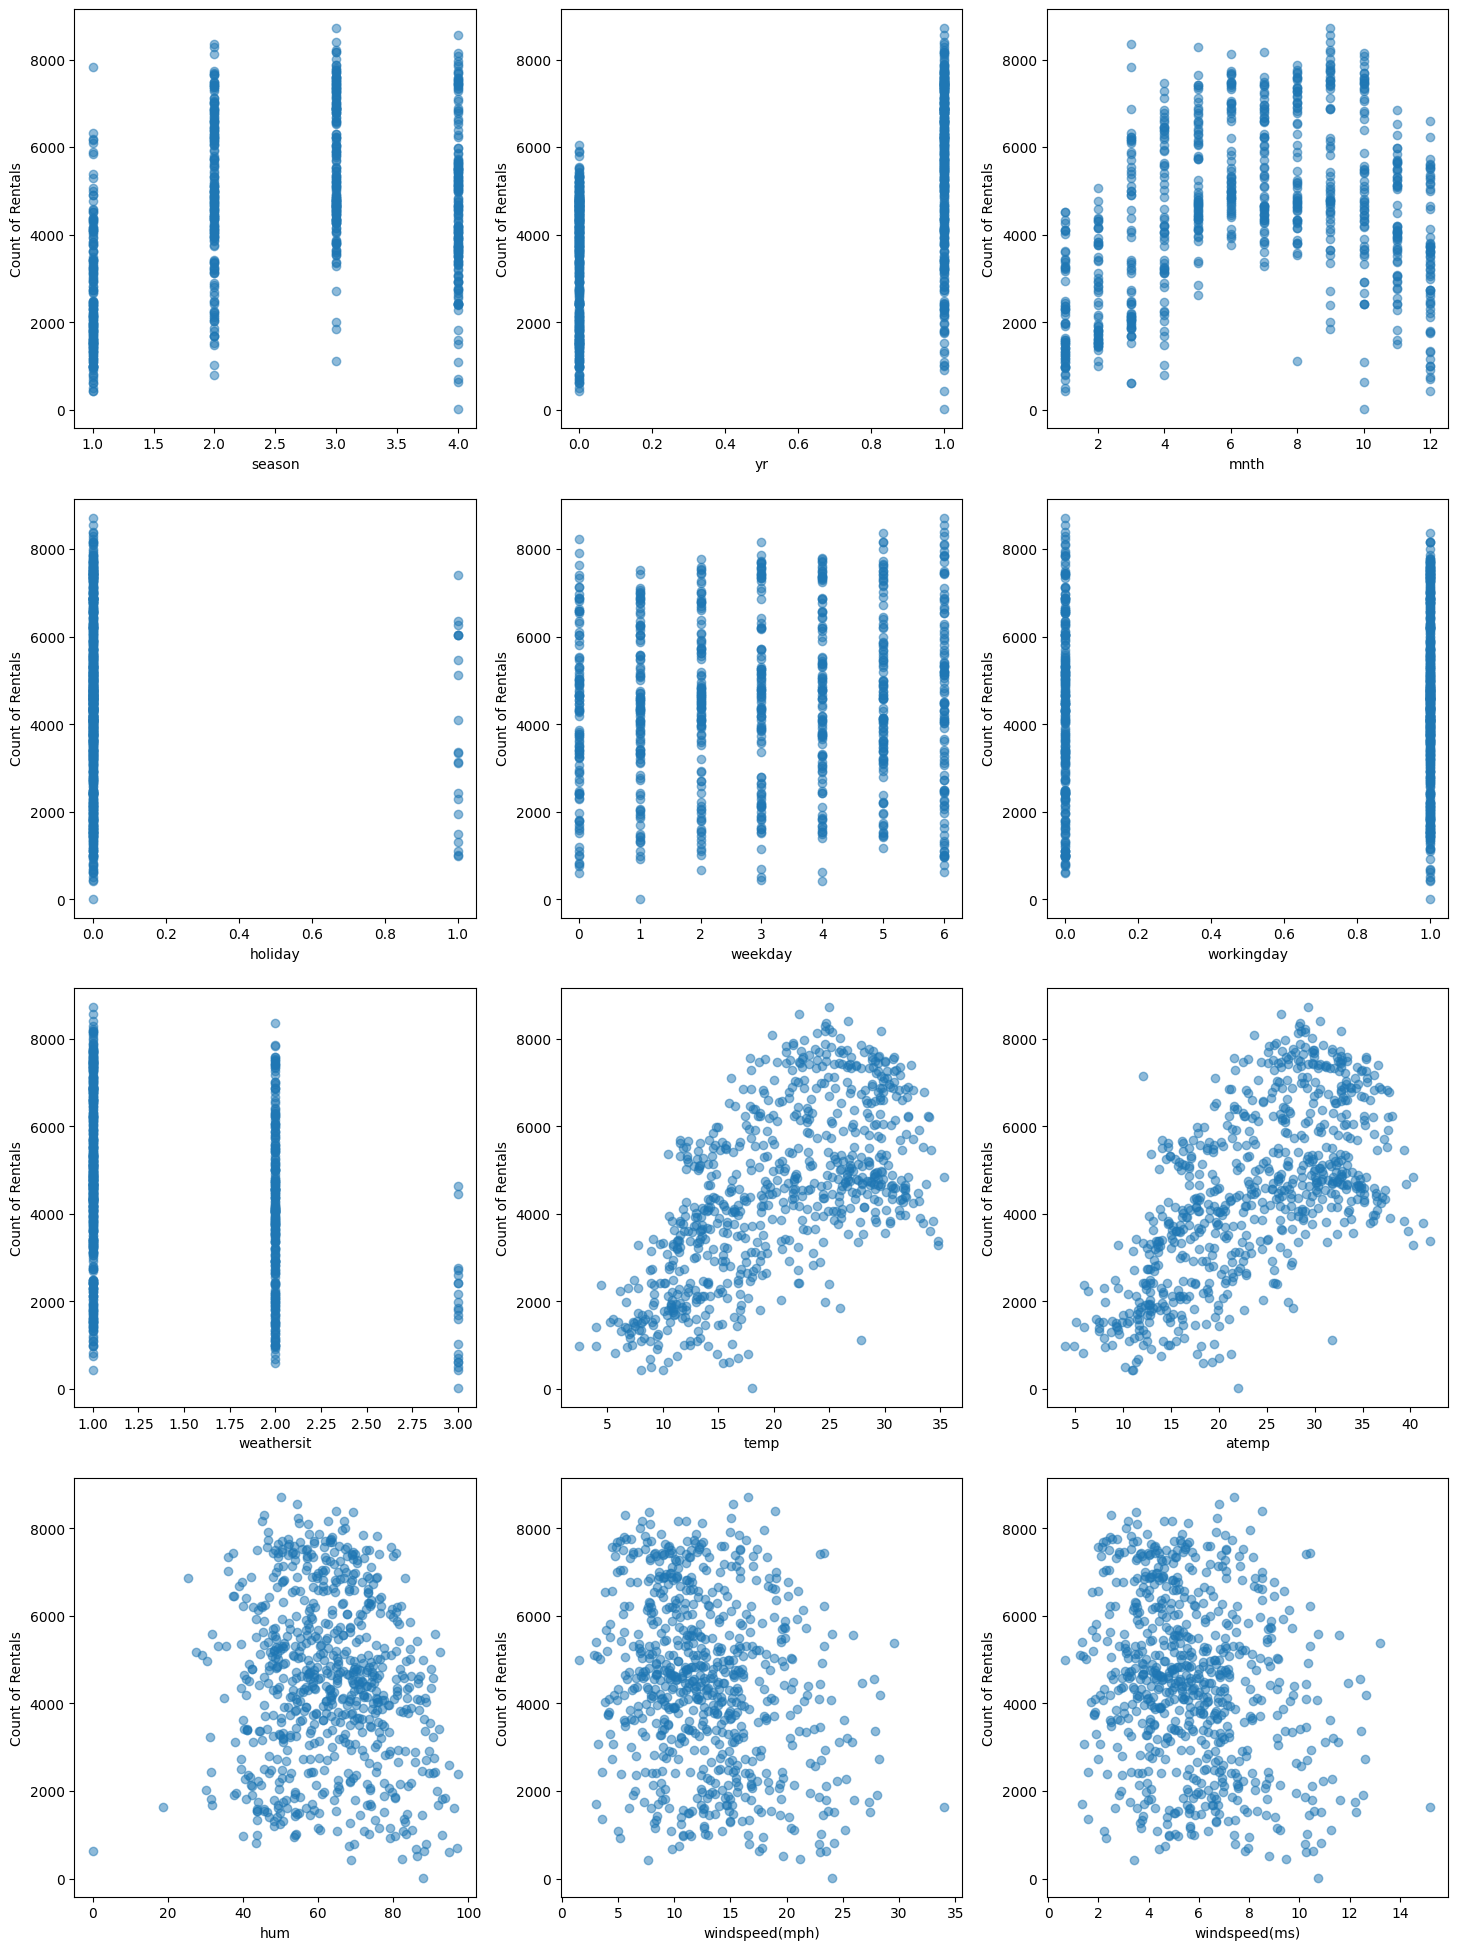

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = "D:/PythonProjects/MY_PYTHON_WAY/PYTHON_DATA-SCIENS/HomeWork_4/bikes_rent.csv"
df = pd.read_csv(file_path)


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
fig.tight_layout(pad=3.0)


features = df.columns[:-1]

for i, feature in enumerate(features):
    row, col = i // 3, i % 3
    axes[row, col].scatter(df[feature], df['cnt'], alpha=0.5)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count of Rentals')

plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Відповіді :

1. Характер залежності кількості прокатів від місяця може бути сезонним. Наприклад, влітку, коли погода сприятлива, більше людей можуть користуватися велопрокатом, ніж взимку, коли температура нижче. Тому можна очікувати, що залежність буде найсильнішою влітку (місяці 6-9), коли найбільше прокатів.

2. Ознаки, від яких кількість прокатів скоріше за все залежить лінійно, це температура (temp або atemp) та вологість (hum). Люди часто вирішують взяти велосипед на прокат, враховуючи ці фактори: вони вибирають дні з приємною температурою та комфортною вологістю. Тому можна очікувати, що залежність кількості прокатів від цих ознак буде лінійною.







## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [9]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [10]:
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
correlation_matrix = df[selected_features].corr()
correlation_matrix

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [11]:
feature_means = df.mean()
print(feature_means)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [12]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [13]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [14]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df.drop('cnt', axis=1), df['cnt'])
weights = list(zip(df.columns[:-1], model.coef_))
print(weights)

[('season', 514.2746214222318), ('yr', 2043.9347266992577), ('mnth', -40.962732189660954), ('holiday', -519.3787167507071), ('weekday', 68.4951552637936), ('workingday', 121.29315570904183), ('weathersit', -606.4507641729948), ('temp', 48.994375424169846), ('atemp', 71.91595392715395), ('hum', -10.230792196371253), ('windspeed(mph)', 2400962890715.9336), ('windspeed(ms)', -5370953986616.345)]


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [20]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X, y)
lasso_weights = list(zip(df.columns[:-1], lasso_model.coef_))
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")

season: 560.2416160308862
yr: 1019.4634940657196
mnth: -128.7306270367869
holiday: -86.15278133371095
weekday: 137.3478939049631
workingday: 55.21237064135677
weathersit: -332.3698569623486
temp: 376.36323620969597
atemp: 576.5307935045538
hum: -144.129155003486
windspeed(mph): -197.13968940248404
windspeed(ms): -2.8051512738133662e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [21]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X, y)
ridge_weights = list(zip(df.columns[:-1], ridge_model.coef_))
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")# Put your code here

season: 563.0645722520193
yr: 1018.9483787875306
mnth: -131.8733202824786
holiday: -86.74609799709202
weekday: 138.00511117871915
workingday: 55.903110375064806
weathersit: -332.3497884990724
temp: 386.4578891919171
atemp: 566.3470470600581
hum: -145.07132729867268
windspeed(mph): -99.25944108181756
windspeed(ms): -99.25944115431525


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [22]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 50)

coefs_lasso = []  
coefs_ridge = []  

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)
    
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)


for i, alpha in enumerate(alphas):
    print(f"Alpha: {alpha}")
    print(f"Lasso Coefficients: {coefs_lasso[i]}")
    print(f"Ridge Coefficients: {coefs_ridge[i]}")
    print("="*30)

Alpha: 1
Lasso Coefficients: [ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
  1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
  5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80515127e-08]
Ridge Coefficients: [ 563.06457225 1018.94837879 -131.87332028  -86.746098    138.00511118
   55.90311038 -332.3497885   386.45788919  566.34704706 -145.0713273
  -99.25944108  -99.25944115]
Alpha: 51
Lasso Coefficients: [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
  9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
  6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29890301e-08]
Ridge Coefficients: [ 461.1786324   954.30774189  -41.56545001  -84.91347027  126.60366663
   54.2516911  -313.27515141  458.90147709  481.44350031 -151.29101033
 -101.62731482 -101.62731483]
Alpha: 101
Lasso Coefficients: [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
  4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
  6.3

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

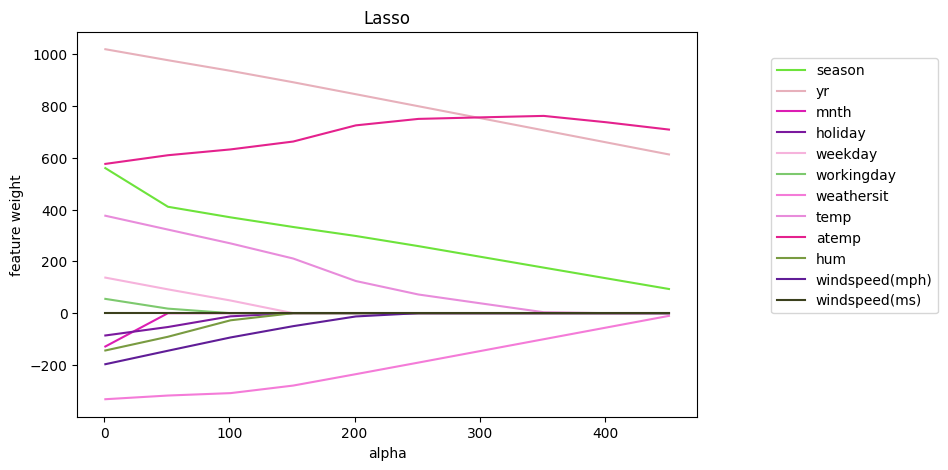

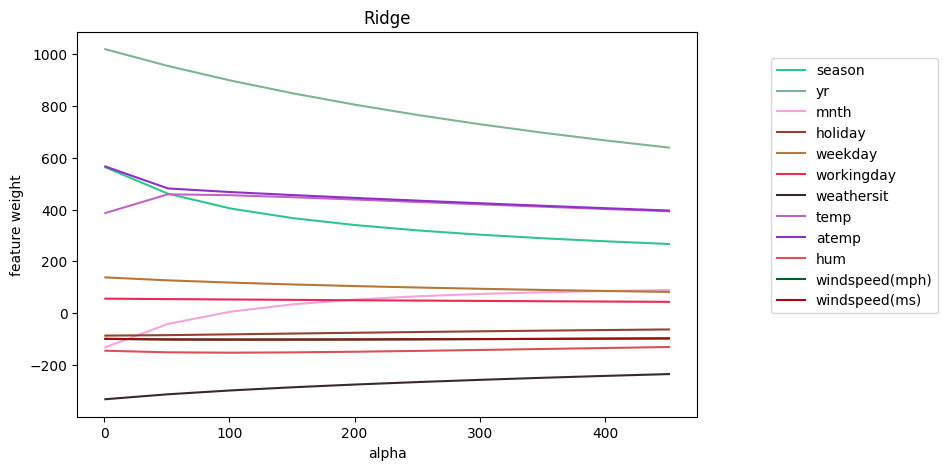

In [25]:
plt.figure(figsize=(8, 5))

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
4. Який із регуляризаторів підійде для відбору неінформативних ознак?


Відповіді :

1.На графіках видно, що Lasso агресивніше зменшує ваги при одному і тому ж alpha. Це можна побачити з того, що ваги в Lasso швидше зменшуються до нуля порівняно з Ridge.

2.Якщо alpha зробити дуже великим у Lasso, то всі ваги ознак будуть зменшені до нуля. Це відбувається через те, що Lasso використовує L1-регуляризацію, яка штрафує за абсолютні значення ваг. Чим більше alpha, тим більш сильний штраф, що призводить до зменшення ваг до нуля.

3.Так, Lasso виключає одну з ознак windspeed при будь-якому значенні alpha > 0, оскільки Lasso використовує L1-регуляризацію, яка схильна обирати лише деякі ознаки і зменшувати коефіцієнти до нуля. У випадку Ridge це можливо тільки при дуже великих значеннях alpha, оскільки він використовує L2-регуляризацію, яка штрафує за квадрати ваг.

4.Lasso підійде для відбору неінформативних ознак, оскільки він має властивість обирати лише деякі ознаки і зменшувати коефіцієнти до нуля. Таким чином, ваги неінформативних ознак швидше зменшаться до нуля порівняно з Ridge.








### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [32]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

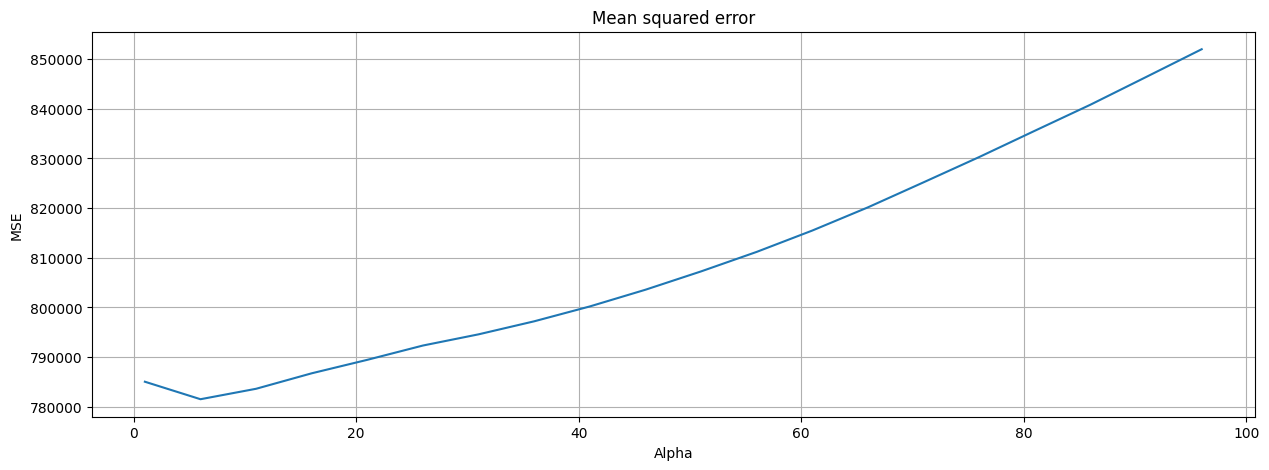

Selected alpha: 6
Feature coefficients:
season: 532.0189828413536
yr: 1015.0602226430597
mnth: -100.03952614356652
holiday: -83.2939598752991
weekday: 132.50446549095793
workingday: 51.557085614074055
weathersit: -330.5598567399815
temp: 370.67985503003166
atemp: 581.3969310655002
hum: -140.00740550068855
windspeed(mph): -191.7714084713498
windspeed(ms): -2.6855326892515688e-08


In [34]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)
regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)

mse_mean = np.mean(regressor.mse_path_, axis=1)
create_plot(list(zip(regressor.alphas_, mse_mean)), "Mean squared error", "Alpha", "MSE")
print("Selected alpha:", regressor.alpha_)
print("Feature coefficients:")
for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [37]:
min_indices = np.argmin(regressor.mse_path_, axis=0)
min_alphas = regressor.alphas_[min_indices]
min_mse = regressor.mse_path_[min_indices, range(regressor.mse_path_.shape[1])]

print("Alphas with minimum MSE:")
for alpha, mse in zip(min_alphas, min_mse):
    print(f"Alpha = {alpha}, MSE = {mse}")

Alphas with minimum MSE:
Alpha = 6, MSE = 733725.760405224
Alpha = 1, MSE = 799433.1673691698
Alpha = 51, MSE = 796979.8955193625


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Four features with the highest positive coefficients:
yr: 1015.0602226430597
atemp: 581.3969310655002
season: 532.0189828413536
temp: 370.67985503003166


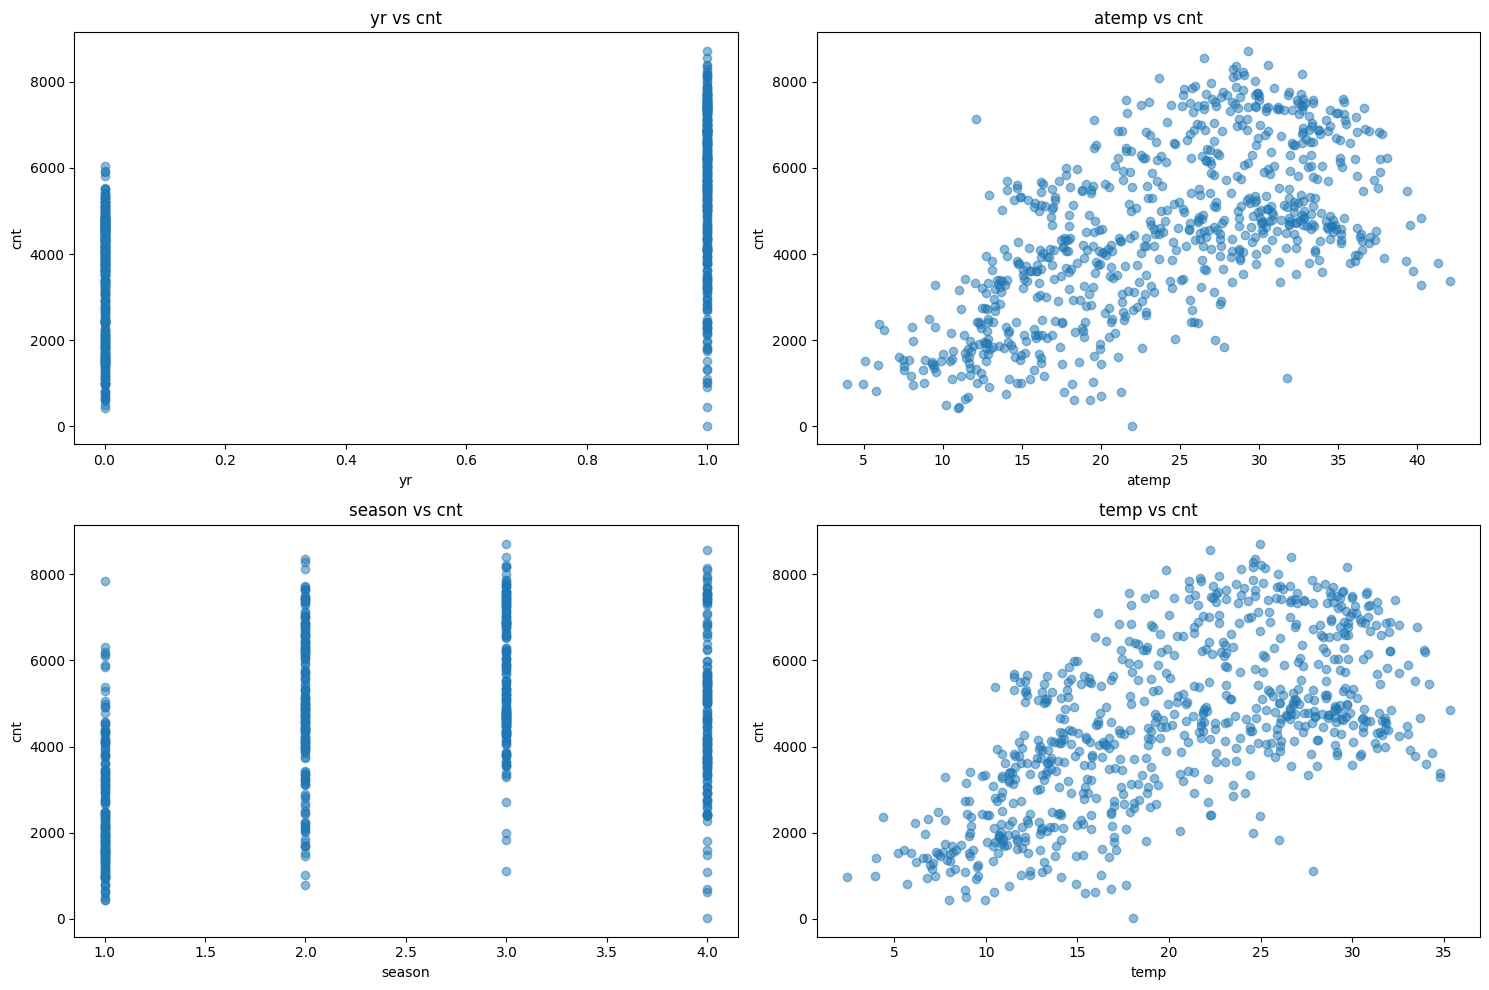

In [38]:
top_features_positive = sorted(zip(regressor.coef_, df.columns[:-1]), reverse=True)[:4]

# Виведення вибраних ознак
print("Four features with the highest positive coefficients:")
for coef, feature in top_features_positive:
    print(f"{feature}: {coef}")

# Побудова візуалізацій залежностей cnt від вибраних ознак
plt.figure(figsize=(15, 10))
for i, (coef, feature) in enumerate(top_features_positive, 1):
    plt.subplot(2, 2, i)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Three features with the highest absolute negative coefficients:
weathersit: -330.5598567399815
windspeed(mph): -191.7714084713498
hum: -140.00740550068855


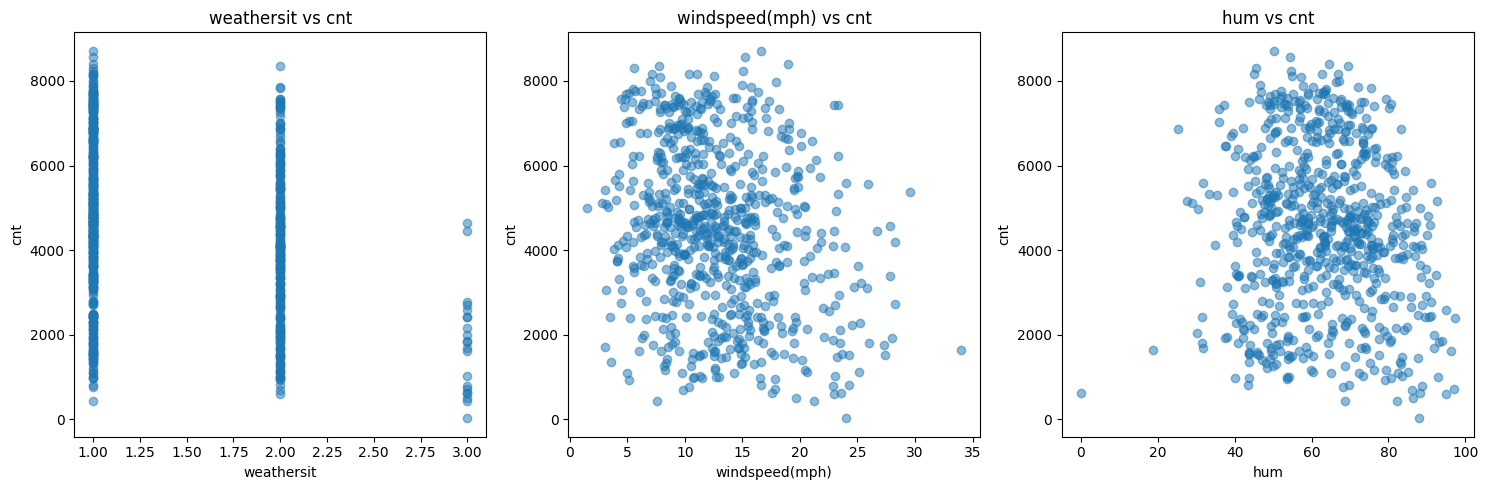

In [39]:
# Вибір трьох ознак з найбільшими за модулем негативними коефіцієнтами
top_features_negative = sorted(zip(regressor.coef_, df.columns[:-1]))

# Виведення вибраних ознак
print("Three features with the highest absolute negative coefficients:")
for coef, feature in top_features_negative[:3]:
    print(f"{feature}: {coef}")

# Побудова візуалізацій залежностей cnt від вибраних ознак
plt.figure(figsize=(15, 5))
for i, (coef, feature) in enumerate(top_features_negative[:3], 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [40]:
features_close_to_zero = [(coef, feature) for coef, feature in zip(regressor.coef_, df.columns[:-1]) if abs(coef) < 1e-3]

# Виведення вибраних ознак
print("Features with coefficients close to zero (< 1e-3):")
for coef, feature in features_close_to_zero:
    print(f"{feature}: {coef}")

Features with coefficients close to zero (< 1e-3):
windspeed(ms): -2.6855326892515688e-08


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.